In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu
from scipy.stats import norm

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';', index_col=0)

In [3]:
df.value = df.value.str.replace(',', '.')

In [4]:
control = df.query('experimentVariant=="Control"').astype({'value': 'float'})
test = df.query('experimentVariant=="Treatment"').astype({'value': 'float'})

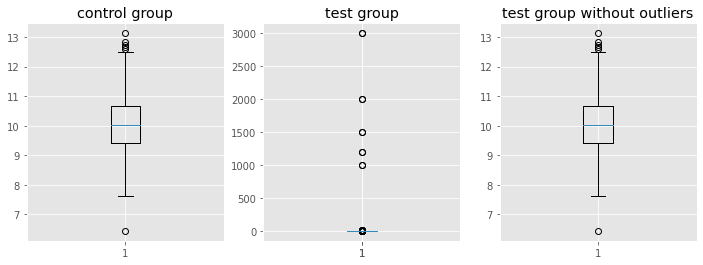

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.boxplot(control.value);
ax1.set_title('control group')
ax2.boxplot(test.value);
ax2.set_title('test group');
ax2.boxplot(test.value);
ax3.set_title('test group without outliers');
ax3.boxplot(test.value[0:-6]);

In [6]:
print('control:', control.shape)
print('test:', test.shape)

control: (500, 2)
test: (500, 2)


In [7]:
test.sort_values(by='value', ascending=False).head(6)

,value,experimentVariant
1000,3000.000000,Treatment
999,2000.000000,Treatment
998,1500.000000,Treatment
997,1200.000000,Treatment
996,1000.000000,Treatment
672,13.130346,Treatment


In [28]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95):
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # Создание bootstrap-выборок и значений статистики
    for i in tqdm(range(boot_it)):
        sample_1 = data_column_1.sample(boot_len, replace=True).values
        sample_2 = data_column_2.sample(boot_len, replace=True).values
        boot_data.append(statistic(sample_1 - sample_2))
    
    pd_boot_data = pd.DataFrame(boot_data)

    # Задание двух краёв уровня значимости
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    # Расчёт p-value для оценки значимости изменений
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [29]:
df = pd.DataFrame({
    "control": control.value.values,
    "test": test.value.values
})

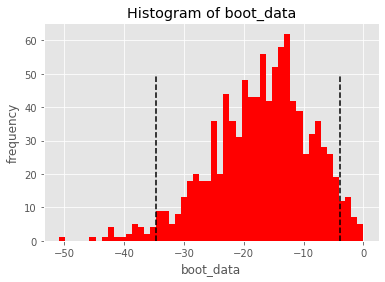

In [30]:
booted_data = get_bootstrap(df.control, df.test) # в результате хранится разница двух распределений, ДИ и pvalue

In [31]:
booted_data["quants"]

,0
0.025,-34.650549
0.975,-3.870040


In [32]:
bootstrap_mean_pvalue = booted_data["p_value"]
booted_data["p_value"]

0.03688577421068571

In [33]:
mannwhitneyu(df.control, df.test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

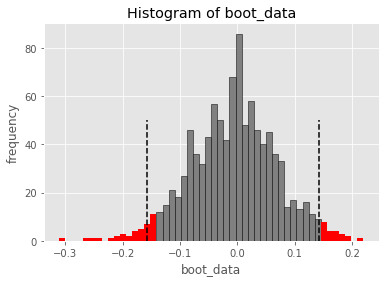

In [34]:
booted_data_median = get_bootstrap(df.control, df.test, statistic=np.median)

In [15]:
bootstrap_median_pvalue = booted_data_median["p_value"]
booted_data_median["p_value"]

0.889384635154199

# Выводы

В данном анализе было проведено исследование метрики для двух групп (test и control) с помощью метода bootstrap.  
В ходе анализа были рассчитаны распределения средней и медианной разницы значений метрики для обеих исследуемых групп.  
Использованный порог значимости составил 95%, количество а bootstrap-выборок в каждом случае - 1000.

- При анализе распределения средней разницы, было обнаружено статистически значимое различие между двумя группами.  
Значение p-value в этом случае составило ***0.03689***, а само распределение смещено относительно нуля   

- Распределение средней медианной разницы оказалось более симметричным, несмещённым относительно 0  
Значение соответствующего p-value составило ***0.88938***, что говорит о статистически незначимом различии медианных значений метрики в обеих группах.

- Полученные значения p-value сравнивались с непараметрическим критерием Манна-Уитни, значение p-value которого оказалось равно 0.42961  
Данная величина находится примерно посередине между медианным p-value и средним p-value

В итоге можно сделать следующие выводы:  
В тестовой выборке присутствуют значительные выбросы, которые ощутимо смещают оценку *среднего* и bootstrap показывает статзначимый результат.  
*Непараметрический ритерий Манна-Уитни*, как известно, обладает некоторой устойчивостью к выбросам и показывает относительно высокое значение p-value, явно указывающие на отсутсвтие статзначимой разницы между группами.  
А при работе с *медианой*, влияние небольшого количества выбросов практически нивелируется, что приводит к самому большому значению p-value